In [1]:
import torch
import numpy as np

from utils.utils import *
from utils.dataloader import *
from utils.nop import *

import matplotlib.pyplot as plt

/home/marlon/miniconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data and model location
data_path = 'data/era5_Santos_2022-2023.nc'
bath_path = 'data/era5_Santos_2022-2023_bath.nc'

model_path = 'models/model_nm600_1250_ds300.0_r350.0_w20_kw40_d8_rl100.pt'

device = torch.device('cuda')

In [3]:
# Load model
model_data = torch.load(model_path, map_location=device)
pars = model_data['pars']

model = KernelNN(pars['model']['width'], pars['model']['kernel_width'], pars['model']['depth'], 3, in_width=3, out_width=1).to(device)
model.load_state_dict(model_data['model'])
model.eval()

KernelNN(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (conv1): NNConv_old(20, 20)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [4]:
# Case for evaluation
test_case_n = 100
#Second test case -> 90
n_verticess = [250, 500, 1000, 1500]
n_neighbors = 0
radius = pars['mesh']['radius']

IOAs = []
MAEs = []
RMSEs = []
MAXEs = []
MAXHs = []

In [5]:
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

In [6]:
# Load data and run model
d = data_loader(data_path,bath_path)
for n_vertices in n_verticess:
    IOA_temp = []
    MAE_temp = []
    RMSE_temp = []
    MAXE_temp = []
    MAXH_temp = []

    for test_case in range(test_case_n):
        print(test_case)

        test_data = d.sample_graph(n_vertices, test_case, radius=radius, n_connections=0, validation=True, seed=0).to(device)

        X = test_data.coords
        F = test_data.x.cpu().detach().numpy()
        G_t = test_data.y.cpu().detach().numpy()

        with torch.no_grad():
            G_p = model(test_data).cpu().detach().numpy()[:,0]


        lat = X[:,0]
        lon = X[:,1]

        wind_u = F[:,0]/d.wind_norm
        wind_v = F[:,1]/d.wind_norm
        bath = F[:,2]/d.bath_norm

        shww_t = G_t/d.shww_norm
        shww_p = G_p/d.shww_norm

        D_sea = test_data.D_sea.cpu().detach().numpy()

        vals_t = shww_t[D_sea>pars['train']['distance_to_sea']]
        vals_p = shww_p[D_sea>pars['train']['distance_to_sea']]

        #IOA_temp += ioa(vals_t,vals_p)
        #MAE_temp += np.mean(np.abs(vals_t-vals_p))
        #RMSE_temp += np.sqrt(np.mean(np.square(vals_t-vals_p)))
        #MAXE_temp += np.abs(np.max(vals_t)-np.max(vals_p))

        IOA_temp.append(ioa(vals_t,vals_p))
        MAE_temp.append(np.mean(np.abs(vals_t-vals_p)))
        RMSE_temp.append(np.sqrt(np.mean(np.square(vals_t-vals_p))))
        MAXE_temp.append(np.abs(np.max(vals_t)-np.max(vals_p)))
        MAXH_temp.append(np.max(vals_t))

    #IOAs.append(IOA_temp/test_case_n)
    #MAEs.append(MAE_temp/test_case_n)
    #RMSEs.append(RMSE_temp/test_case_n)
    #MAXEs.append(MAXE_temp/test_case_n)

    IOAs.append(IOA_temp)
    MAEs.append(MAE_temp)
    RMSEs.append(RMSE_temp)
    MAXEs.append(MAXE_temp)
    MAXHs.append(MAXH_temp)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

In [7]:
print(IOAs)
print(MAEs)
print(RMSEs)
print(MAXEs)

[[0.4389795660972595, 0.6093476414680481, 0.561637669801712, 0.4561241865158081, 0.5091825723648071, 0.6877796053886414, 0.6625757217407227, 0.752029538154602, 0.742265909910202, 0.4761839509010315, 0.6587939262390137, 0.5056314468383789, 0.3964691162109375, 0.6426586210727692, 0.6501633524894714, 0.4556160569190979, 0.8114956319332123, 0.6994689106941223, 0.3908407688140869, 0.7318898141384125, 0.6066188812255859, 0.7102667987346649, 0.48356789350509644, 0.7012609243392944, 0.7736233919858932, 0.32452428340911865, 0.5248482525348663, 0.7358580827713013, 0.5351217985153198, 0.36126387119293213, 0.652025580406189, 0.6244394183158875, 0.4479360580444336, 0.37746119499206543, 0.738740861415863, 0.6076891422271729, 0.6929620504379272, 0.6406782567501068, 0.6695848405361176, 0.733385443687439, 0.7224139869213104, 0.7265665531158447, 0.5448693037033081, 0.848386824131012, 0.6749608516693115, 0.7050155103206635, 0.6547764241695404, 0.34624332189559937, 0.44506019353866577, 0.647166907787323, 

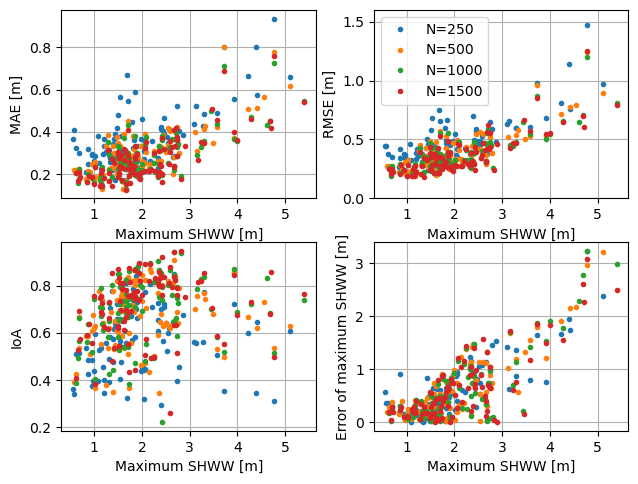

In [58]:

fig, ax = plt.subplots(2, 2)
fig.tight_layout()

for n_case in range(4):

    MAE = np.array(MAEs[n_case])
    RMSE = np.array(RMSEs[n_case])
    IOA = np.array(IOAs[n_case])
    MAXE = np.array(MAXEs[n_case])
    MAXH = np.array(MAXHs[n_case])

    plt.subplot(2,2,1)
    plt.plot(MAXH,MAE,'.')
    plt.xlabel('Maximum SHWW [m]')
    plt.ylabel('MAE [m]')
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.plot(MAXH,RMSE,'.')
    plt.xlabel('Maximum SHWW [m]')
    plt.ylabel('RMSE [m]')
    plt.ylim((0,1.6))
    plt.grid(True)

    plt.subplot(2,2,3)
    plt.plot(MAXH,IOA,'.')
    plt.xlabel('Maximum SHWW [m]')
    plt.ylabel('IoA')
    plt.grid(True)

    plt.subplot(2,2,4)
    plt.plot(MAXH,MAXE,'.')
    plt.xlabel('Maximum SHWW [m]')
    plt.ylabel('Error of maximum SHWW [m]')
    plt.grid(True)

plt.subplot(2,2,2)
plt.legend(['N=250','N=500','N=1000','N=1500'])

plt.savefig('errors.pdf',bbox_inches = "tight")

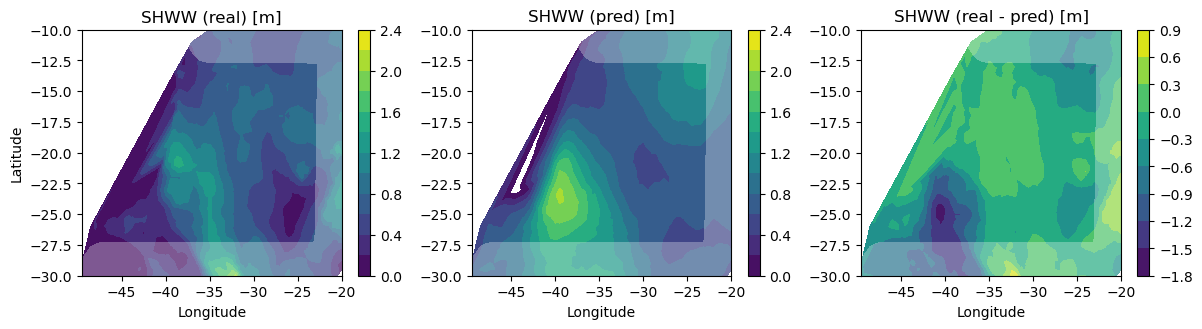

In [9]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(12,3))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(1,3,1)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1,3,2)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplot(1,3,3)
plt.tricontourf(lon,lat,shww_t-shww_p,n_contours)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (real - pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.90, bottom=0.08)
#plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

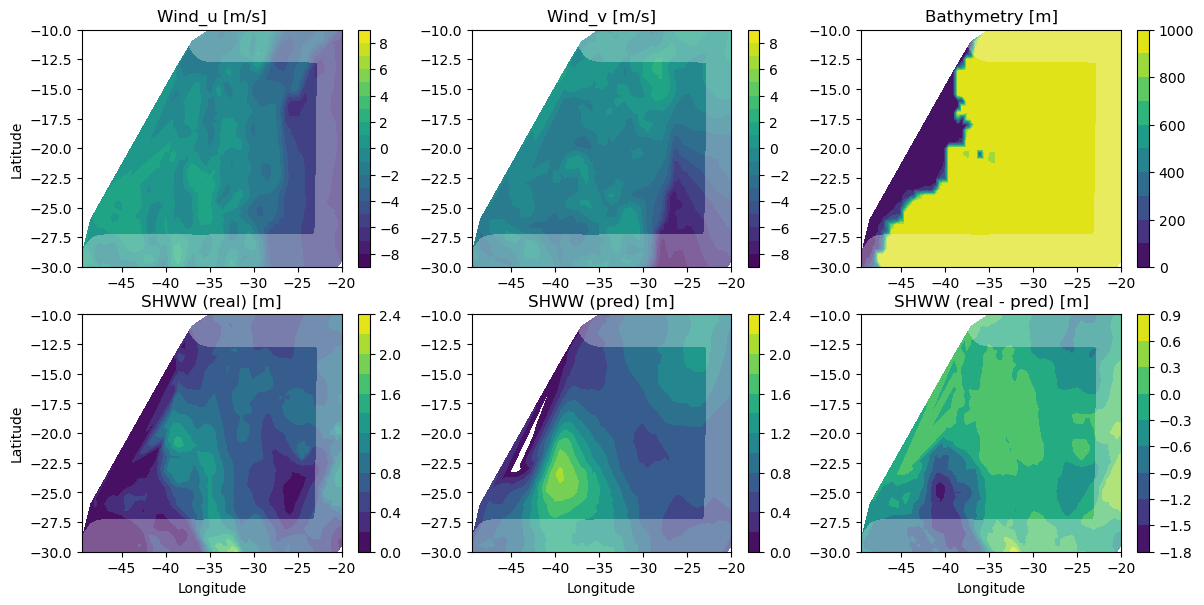

In [10]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(12,6))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(2,3,1)
plt.tricontourf(lon,lat,wind_u,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_u [m/s]')
plt.ylabel('Latitude')

plt.subplot(2,3,2)
plt.tricontourf(lon,lat,wind_v,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_v [m/s]')

plt.subplot(2,3,3)
plt.tricontourf(lon,lat,bath,contours_bath)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Bathymetry [m]')

plt.subplot(2,3,4)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,3,5)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplot(2,3,6)
plt.tricontourf(lon,lat,shww_t-shww_p,n_contours)
#plt.tricontourf(lon,lat,(shww_t-shww_p)/(shww_t+1e-10),np.linspace(-1,1,n_contours))
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (real - pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.95, bottom=0.08)
plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

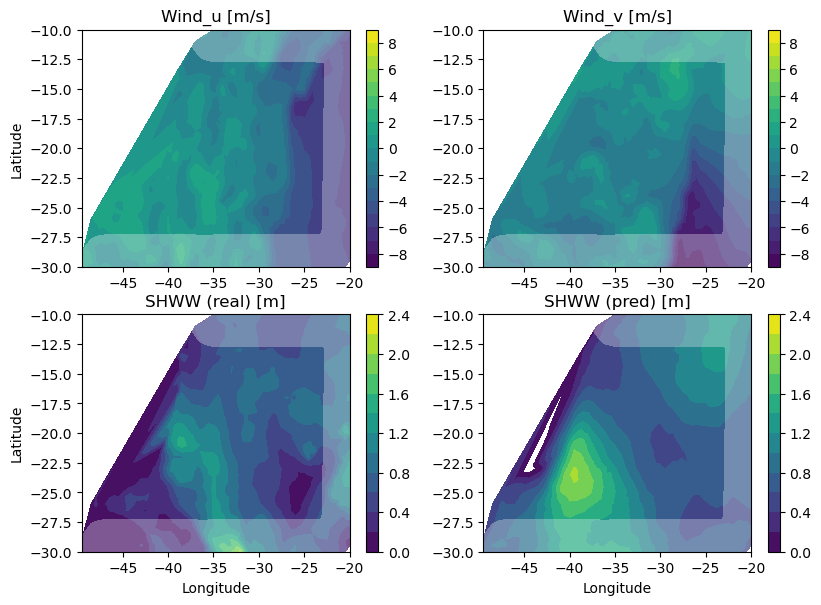

In [11]:
# Plot results
n_contours = 8
wind_step = 1
wave_step = 0.2

plt.figure(figsize=(8,6))

wind_max = wind_step*np.ceil(np.max((np.max(np.abs(wind_u)),np.max(np.abs(wind_v))))/wind_step)
wave_max = wave_step*np.ceil(np.max((np.max(np.abs(shww_t)),np.max(np.abs(shww_p))))/wave_step)

contours_wind = np.arange(-wind_max,wind_max+wind_step,wind_step)#wind_max*np.linspace(-1,1,n_contours)
contours_bath = np.linspace(0,1000,11)
contours_wave = np.arange(0,wave_max+wave_step,wave_step)#wave_max*np.linspace(0,1,n_contours)
contours_distance = [0, pars['train']['distance_to_sea']]

plt.subplot(2,2,1)
plt.tricontourf(lon,lat,wind_u,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_u [m/s]')
plt.ylabel('Latitude')

plt.subplot(2,2,2)
plt.tricontourf(lon,lat,wind_v,contours_wind)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('Wind_v [m/s]')

plt.subplot(2,2,3)
plt.tricontourf(lon,lat,shww_t,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.title('SHWW (real) [m]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,2,4)
plt.tricontourf(lon,lat,shww_p,contours_wave)
plt.colorbar()
plt.tricontourf(lon,lat,D_sea,contours_distance,colors='w',alpha = 0.3)
plt.xlabel('Longitude')
plt.title('SHWW (pred) [m]')

plt.subplots_adjust(left=0.07, right=0.99, top=0.95, bottom=0.08)
plt.savefig(f'prediction_c{test_case}_v{n_vertices}.pdf')

In [12]:
# Print metrics
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

print(f'MSE: {np.mean(np.square(d.shww_norm*(shww_p-shww_t)))}')
print(f'MAE: {np.mean(np.abs(d.shww_norm*(shww_p-shww_t)))}')
print(f'IOA: {ioa(shww_p,shww_t)}')

MSE: 0.6331971287727356
MAE: 0.5545952320098877
IOA: 0.5194604992866516


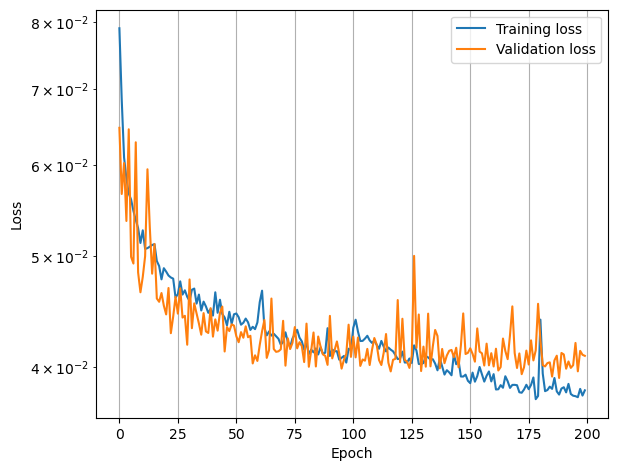

In [13]:
# Plot loss during training
plt.semilogy(model_data['loss'],label='Training loss')
plt.semilogy(model_data['loss_val'],label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)
plt.savefig('loss_history.pdf')

In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18881